Datensatz für den Tokenizer ready machen
labels anpassen (0,1,2)
args für das Model setzen
trainieren
evaluieren

an parametern rumspielen



---



In [1]:
!pip install torch torchvision
!pip install transformers

In [ ]:
!nvidia-smi

Sun Nov 19 21:48:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  | 00000000:06:00.0  On |                  Off |
|  0%   33C    P8              24W / 450W |   1933MiB / 24564MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np


In [3]:
df_train = pd.read_csv(r'C:\Users\lande\Downloads\comparg_train (1).tsv', sep='\t', encoding='utf-8')
df_test = pd.read_csv(r'C:\Users\lande\Downloads\comparg_test (1).tsv', sep='\t', encoding='utf-8')
df_test_russian = pd.read_csv(r'C:\Users\lande\Downloads\ru_sentences_with_objs.tsv', sep='\t', encoding='utf-8')


In [4]:
# korrigiere labels
df_train['labels'] = df_train['labels'].replace({2: 1})
df_train['labels'] = df_train['labels'].replace({3: 2})

df_test['labels'] = df_test['labels'].replace({2: 1})
df_test['labels'] = df_test['labels'].replace({3: 2})



In [ ]:
print(df_train)

        object_0   object_1  \
0           Dell      Intel   
1            mit    harvard   
2      Microsoft       Sony   
3       Ethernet  Bluetooth   
4         Toyota       Ford   
...          ...        ...   
5754   Chevrolet       Ford   
5755  PostgreSQL     Oracle   
5756        Java     Python   
5757  JavaScript        PHP   
5758   Windows 7  Windows 8   

                                                 answer  labels  
0     Frankly, like a procession of formerly-consist...       0  
1                                          mit, harvard       0  
2     It also didn't hurt my faith in Microsoft when...       1  
3     You can probably find the Onkyo TX-NR717 for m...       0  
4     I liked the Toyota over the Ford and it looks ...       1  
...                                                 ...     ...  
5754  I drive a Chevrolet Trailblazer...not much dif...       1  
5755  migration tool and an editor of your choice Ex...       0  
5756  Regarding this C/C++/D/Java

In [5]:
df_test_russian['tag'] = df_test_russian['tag'].replace({"NONE": 0})
df_test_russian['tag'] = df_test_russian['tag'].replace({"BETTER": 1})
df_test_russian['tag'] = df_test_russian['tag'].replace({"WORSE": 2})

In [ ]:
print(df_test_russian['tag'])

0       0
1       0
2       0
3       2
4       0
       ..
1203    0
1204    0
1205    0
1206    1
1207    0
Name: tag, Length: 1208, dtype: int64


In [6]:
#norm objects
import re

def mask_objects(row):
    row["answer"] = re.sub(re.escape(row["object_0"]), "[FIRST_ENTITY]", row["answer"], flags=re.IGNORECASE)
    row["answer"] = re.sub(re.escape(row["object_1"]), "[SECOND_ENTITY]", row["answer"], flags=re.IGNORECASE)
    return row


def transform_data(df):
  df = df.apply(mask_objects,axis=1)
  return df


df_train = transform_data(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = transform_data(df_test)




In [7]:
df_full = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
print(df_train)

             object_0      object_1  \
0     Hewlett-Packard          Dell   
1               Apple        Google   
2               pizza       sausage   
3               Apple         Intel   
4              Oracle         MySQL   
...               ...           ...   
5754         virginia  pennsylvania   
5755             soup         pasta   
5756             Lisp        Python   
5757              USB     Bluetooth   
5758       restaurant          cafe   

                                                 answer  labels  
0     Nokia towered over its rivals in ways that Toy...       0  
1     For better or worse, a majority of people stil...       0  
2     Moral disputes are like disputes about whether...       1  
3     Notice that [FIRST_ENTITY] no longer develop i...       0  
4            Would [FIRST_ENTITY] Harm [SECOND_ENTITY]?       0  
...                                                 ...     ...  
5754                 [FIRST_ENTITY] and [SECOND_ENTITY]       0  
575

In [8]:
#norm objects russian dataset
import string

def mask_objects_ru(row):
    object_1 = row["Object1"].translate(str.maketrans('', '', string.punctuation))
    object_2 = row["Object2"].translate(str.maketrans('', '', string.punctuation))

    if len(object_1.split()) == 1 and len(object_2.split()) == 1:
      row["text"] = " ".join(["[FIRST_ENTITY]" if object_1.lower() in w.lower() else "[SECOND_ENTITY]" if object_2.lower() in w.lower() else w for w in row["text"].split()])

    elif len(object_1.split()) > 1 and len(object_2.split()) == 1:
      out = []
      for w in row["text"].split():
        for o1 in object_1.lower().split():
          if o1 in w.lower() and "[FIRST_ENTITY]" not in out and w.lower() not in [w.lower() for w in out]:
            out.append("[FIRST_ENTITY]")
            break
          elif object_2.lower() in w.lower() and "[SECOND_ENTITY]" not in out:
            out.append("[SECOND_ENTITY]")
            break
          else:
            if w.lower() not in [w.lower() for w in out] and w.lower() not in object_1.lower().split() and w.lower() not in object_2.lower().split():
              out.append(w)
      row["text"] = " ".join(out)

    elif len(object_1.split()) == 1 and len(object_2.split()) > 1:
      out = []
      for w in row["text"].split():
        for o2 in object_2.lower().split():
          if o2 in w.lower() and "[SECOND_ENTITY]" not in out and w.lower() not in [w.lower() for w in out]:
            out.append("[SECOND_ENTITY]")
            break
          elif object_1.lower() in w.lower() and "[FIRST_ENTITY]" not in out:
            out.append("[FIRST_ENTITY]")
            break
          else:
            if w.lower() not in [w.lower() for w in out] and w.lower() not in object_1.lower().split() and w.lower() not in object_2.lower().split():
              out.append(w)
      row["text"] = " ".join(out)

    else:
      row["text"] = row["text"].replace(object_1,"[FIRST_ENTITY]").replace(object_2,"[SECOND_ENTITY]")
      # row["text"] = row["text"].replace(row["object_0"],"[FIRST_ENTITY]").replace(row["object_1"],"[SECOND_ENTITY]")
    return row

def transform_data_ru(df):
  df = df.apply(mask_objects_ru,axis=1)
  return df

In [9]:
df_test_russian = transform_data_ru(df_test_russian)


<Axes: xlabel='labels'>

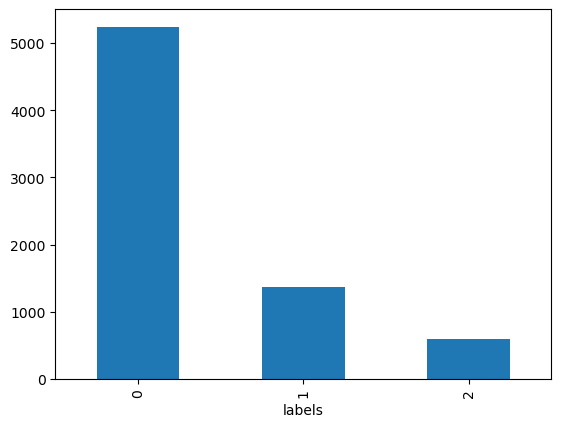

In [10]:
#distribution of full eng data
df_full['labels'].value_counts().sort_index().plot(kind='bar')


<Axes: xlabel='tag'>

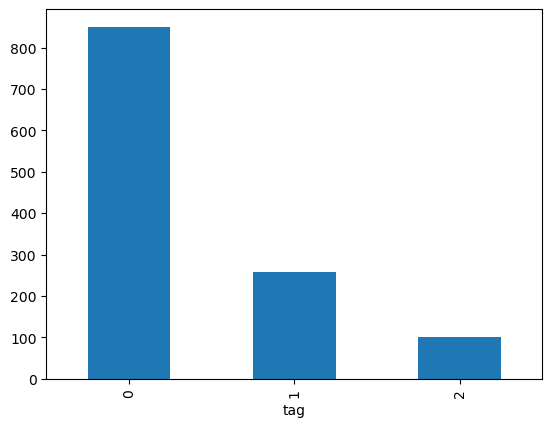

In [12]:
#distribution of russian data
df_test_russian['tag'].value_counts().sort_index().plot(kind='bar')

In [14]:
from transformers import RobertaConfig, AutoTokenizer, AutoModelForSequenceClassification

In [16]:
train_texts = df_train['answer'].tolist()
train_labels = df_train['labels'].tolist()
test_texts = df_test['answer'].tolist()
test_labels = df_test['labels'].tolist()
test_russian_text = df_test_russian['text'].tolist()
test_russian_labels = df_test_russian['tag'].tolist()
full_texts = df_full['answer'].tolist()
full_labels = df_full['labels'].tolist()

In [17]:
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

In [18]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = xlm_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }





In [19]:
max_length = 64
train_dataset = CustomDataset(train_texts, train_labels, xlm_tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, xlm_tokenizer, max_length)
test_russian_dataset = CustomDataset(test_russian_text, test_russian_labels, xlm_tokenizer, max_length = 64)
full_dataset = CustomDataset(full_texts, full_labels, xlm_tokenizer, max_length = 64)

Dataset und DataLoader:

epoch =  forward and backward pass von alles training samples

batch_size = anzahl von training samples pro forward und backward pass

anzahl an interationen = anzahl an forward und backward passes, mit [batch_size] anzahl an samples

-> x samples, batchsize = n -> x/n iterationen pro epoche







In [20]:
from transformers import set_seed
set_seed(42)
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=3)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
!pip install accelerate -U

In [22]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    overwrite_output_dir=True,
    num_train_epochs=5,
    fp16=False,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    output_dir = "C:/Users/lande/Downloads/checkpoints"
    )
data_collator = DataCollatorWithPadding(tokenizer=xlm_tokenizer)

In [ ]:
trainer = Trainer(model = model,
    args = training_args,
    train_dataset = #train_dataset/#full_dataset,
    data_collator = data_collator,
    tokenizer = xlm_tokenizer,)

In [ ]:
trainer.train()

In [ ]:
#outputs russian

outputs_russian = trainer.predict(test_dataset_russian)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

#eval russian_dataset
predictions_russian = outputs_russian.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print("Evaluation on russian dataset:")
print(classification_report(y_true=test_russian_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_russian_dataset.labels, y_pred=predictions_russian, average='micro')}")



Evaluation on russian dataset:
              precision    recall  f1-score   support

     neutral       0.86      0.95      0.90       850
     objekt1       0.79      0.61      0.69       257
     objekt2       0.58      0.41      0.48       101

    accuracy                           0.83      1208
   macro avg       0.74      0.66      0.69      1208
weighted avg       0.82      0.83      0.82      1208

F1-micro: 0.8311258278145697


In [ ]:
#save preds in csv
df_test_russian['preds'] = predictions_russian

output_file_path = r'C:\Users\lande\Downloads\test_russian_xlm_5epochs_full'
df_test_russian.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
#outsputs eng
outputs_eng = trainer.predict(test_dataset)

In [ ]:
predictions_eng = outputs_eng.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print("Evaluation on english dataset:")
print(classification_report(y_true=test_dataset_en.labels, y_pred=predictions_eng, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset_en.labels, y_pred=predictions_eng, average='micro')}")

Evaluation on english dataset:
              precision    recall  f1-score   support

     neutral       0.99      0.99      0.99      1048
     objekt1       0.98      0.96      0.97       273
     objekt2       0.92      0.96      0.94       119

    accuracy                           0.98      1440
   macro avg       0.96      0.97      0.97      1440
weighted avg       0.98      0.98      0.98      1440

F1-micro: 0.9840277777777777


In [ ]:
#save english preds
df_test['preds'] = predictions_eng
df_test.to_csv(r"C:\Users\lande\Downloads\xlm_5epochs_eng", sep='\t' index=True)

In [ ]:
output_model_dir = r'C:\Users\lande\Downloads\Abgabe\xlm_5epochs' #\xlm_5epochs_full
trainer.save_model(output_model_dir)


Der rest hier gehört nicht mehr zum "offiziellen" code

In [ ]:
#preds von 5epochen auf russian_dataset hinzufügen
#df_russian['XLM_5epochs'] = predictions_russian
#df_russian.to_csv(r"C:\Users\lande\Downloads\Abgabe\test_russian.csv", index=False)

In [ ]:
#preds von 6epochen auf russian_dataset hinzufügen
#df_russian['XLM_6epochs_fixed'] = predictions_russian
#df_russian.to_csv(r"C:\Users\lande\Downloads\Abgabe\test_russian.csv", index=False)

In [ ]:
#preds von 5epochen_full auf russian_dataset hinzufügen
#df_russian['XLM_5epochs_full_fixed'] = predictions_russian
#df_russian.to_csv(r"C:\Users\lande\Downloads\Abgabe\test_russian.csv", index=False)

In [ ]:
#df_russian['xlm_6epochs_full_8x2'] = predictions_russian
#output_file_path = r"C:\Users\lande\Downloads\Abgabe\test_russian.csv"
#df_russian.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
#lade Model um nochmal auf df_test  zu testen

In [ ]:
#from transformers import XLMRobertaForSequenceClassification
#model = XLMRobertaForSequenceClassification.from_pretrained("C:/Users/lande/Downloads/finetuned_test_russian_5epochs_s")
#trainer_finetuned = Trainer(model = model,
   # args = training_args,
  #  train_dataset = train_dataset,
   # data_collator = data_collator,
  #  tokenizer = xlm_tokenizer,)


#outputs = trainer_finetuned.predict(test_russian_dataset)

In [ ]:
#predictions_on_russian = outputs.predictions.argmax(-1)
#predictions_on_eng =
#target_names = ["neutral", "objekt1", "objekt2"]
#print(classification_report(y_true=test_russian_dataset.labels, y_pred=predictions_on_russian, target_names=target_names))
#print(f"F1-micro: {f1_score(y_true=test_russian_dataset.labels, y_pred=predictions_on_russian, average='micro')}")


In [ ]:
#Anzahl Zeilen mit fehlgeschlagener Maskierung
wrong_mask_russian =  df_test_russian_transformed[df_test_russian_transformed['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
only_first_entity_russian =  df_test_russian_transformed[df_test_russian_transformed['text'].apply(lambda x: ("[FIRST_ENTITY]" in x and not ("[SECOND_ENTITY]" in x)))]
only_second_entity_russian =  df_test_russian_transformed[df_test_russian_transformed['text'].apply(lambda x: (not ("[FIRST_ENTITY]" in x) and ("[SECOND_ENTITY]" in x)))]
no_mask_russian =  df_test_russian_transformed[df_test_russian_transformed['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x) and not ("[SECOND_ENTITY]" in x))]

print("gesamt:", unmasked_russian['text'].size)

print("nur objekt 1 maskiert:", only_first_entity_russian['text'].size)
print("nur objekt 2 maskiert:", only_second_entity_russian['text'].size)
print("keins maskiert: ", no_mask_russian['text'].size)
print(unmasked_russian['text'].tolist())

wrong_mask_russian.to_csv(r"C:\Users\lande\Downloads\Abgabe\failed_mask_russian", sep='\t')

gesamt: 49
nur objekt 1 maskiert: 36
nur objekt 2 maskiert: 4
keins maskiert:  9
['Что лучше [FIRST_ENTITY] или [FIRST_ENTITY] интернет?', 'Понятно, что когда есть интернет [FIRST_ENTITY] не хочется весь дом опутывать проводами дополнительно, легче его раздать способами [FIRST_ENTITY]', 'Чем больше капелек, тем на дольше хватает [FIRST_ENTITY] до следующей их замены.', 'Почти везде есть [FIRST_ENTITY] или [FIRST_ENTITY] доступ к высокоскоростному и безлимитному интернету, а потому удобнее всего смотреть видео онлайн.', '[FIRST_ENTITY] интернет всегда работает чуть хуже, чем через [FIRST_ENTITY] соединение из-за непрямого подключения к устройству.', 'Но не ждите реального улучшения производительности после использования дефрагментаторов реестра, особенно в более поздних версиях windows, таких как windows [FIRST_ENTITY] / vista.', 'Google pixel xl на 20 грамм легче [SECOND_ENTITY] plus.', 'Все стандарты wifi — чем они отличаются, какой лучше [FIRST_ENTITY] интернет-соединение постепенно 

In [ ]:
unmasked_eng = df_train[df_train['answer'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
print(unmasked_eng['answer'].size)

0


In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
set_seed(42)
model_path = r"C:\Users\lande\Downloads\Abgabe\xlm_finetuned_5epochs_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path)
xlm_5epochs = AutoModelForSequenceClassification.from_pretrained(model_path)


In [59]:
trainer = Trainer(model = xlm_5epochs,
    args = training_args,
    train_dataset = train_dataset,
    data_collator = data_collator,
    tokenizer = xlm_tokenizer,)

In [60]:
outputs_en = trainer.predict(test_dataset)

In [61]:
from sklearn.metrics import classification_report, f1_score
predictions_eng = outputs_en.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print("Evaluation on english dataset:")
print(classification_report(y_true=test_dataset.labels, y_pred=predictions_eng, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset.labels, y_pred=predictions_eng, average='micro')}")

Evaluation on english dataset:
              precision    recall  f1-score   support

     neutral       0.96      0.94      0.95      1048
     objekt1       0.87      0.88      0.87       273
     objekt2       0.65      0.73      0.69       119

    accuracy                           0.91      1440
   macro avg       0.82      0.85      0.84      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9104166666666667


In [62]:
df_test['preds'] = predictions_eng
df_test.to_csv(r"C:\Users\lande\Downloads\xlm_5epochs_preds_en.tsv", sep='\t', index=True)

In [48]:
outputs_ru = outputs_en = trainer.predict(test_russian_dataset)

In [49]:
#eval russian_dataset on 5epochs_only_train
predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print("Evaluation on russian dataset:")
print(classification_report(y_true=test_russian_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_russian_dataset.labels, y_pred=predictions_russian, average='micro')}")

Evaluation on russian dataset:
              precision    recall  f1-score   support

     neutral       0.86      0.95      0.90       850
     objekt1       0.80      0.59      0.68       257
     objekt2       0.58      0.50      0.53       101

    accuracy                           0.83      1208
   macro avg       0.75      0.68      0.71      1208
weighted avg       0.83      0.83      0.82      1208

F1-micro: 0.8327814569536425


In [50]:
#save preds in csv
df_test_russian['preds'] = predictions_russian

output_file_path = r'C:\Users\lande\Downloads\xlm_5epochs_preds_ru.tsv'
df_test_russian.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
#russian preds on full

In [51]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = r"C:\Users\lande\Downloads\Abgabe\xlm_finetuned_5epochs_full_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path)
xlm_5epochs = AutoModelForSequenceClassification.from_pretrained(model_path)

In [52]:
trainer = Trainer(model = xlm_5epochs,
    args = training_args,
    train_dataset = full_dataset,
    data_collator = data_collator,
    tokenizer = xlm_tokenizer,)

In [53]:
outputs_ru = trainer.predict(test_russian_dataset)

In [54]:
#eval russian_dataset on 5epochs_full
predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print("Evaluation on russian dataset:")
print(classification_report(y_true=test_russian_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_russian_dataset.labels, y_pred=predictions_russian, average='micro')}")

Evaluation on russian dataset:
              precision    recall  f1-score   support

     neutral       0.86      0.95      0.91       850
     objekt1       0.87      0.60      0.71       257
     objekt2       0.53      0.48      0.50       101

    accuracy                           0.84      1208
   macro avg       0.76      0.68      0.71      1208
weighted avg       0.84      0.84      0.83      1208

F1-micro: 0.8394039735099338


In [55]:
#save preds in csv
df_test_russian['preds'] = predictions_russian

output_file_path = r'C:\Users\lande\Downloads\xlm_5epochs_full_preds_ru.tsv'
df_test_russian.to_csv(output_file_path, sep='\t', index=False)